In [1]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [2]:
!pip install timm fastai
! pip install -U accelerate
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from fastai.vision.all import *
from fastai import *
import timm
from fastai.vision.all import *
import timm
from fastai.distributed import *
import warnings
warnings.simplefilter("ignore")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.22.0
    Uninstalling accelerate-0.22.0:
      Successfully uninstalled accelerate-0.22.0


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

random_seed(42, True)

In [4]:
path = r'/kaggle/input/raw-paper'
bs = 32
sz = 224

# Define data augmentation transforms

data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(sz),
    splitter=GrandparentSplitter(train_name="train", valid_name="test"),
    batch_tfms = aug_transforms(do_flip=True, flip_vert=True, max_rotate=120.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.3, size=sz))
#   batch_tfms = aug_transforms(mult=1.0, do_flip=True, flip_vert=True, max_rotate=120.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=sz, mode='bilinear', pad_mode='reflection', align_corners=True, batch=False, min_scale=1.0)
# )

In [5]:
dls = data.dataloaders(path, bs=bs)
print("Number of classes: ",dls.c)

Number of classes:  31


In [6]:
# Total number of train samples
train_samples = len(dls.train_ds)

# Total number of test samples
test_samples = len(dls.valid_ds)

print(f"Total train samples: {train_samples}")
print(f"Total test samples: {test_samples}")

Total train samples: 3916
Total test samples: 994


In [7]:
arch = "vit_base_patch16_224"
model = timm.create_model(arch, pretrained=True, in_chans=3, num_classes=dls.c)
#model.head.fc = nn.Sequential(create_cls_module(nf=model.num_features, n_out=dls.c))

In [8]:
path = r'/kaggle/working/'
savedfilename = f'{path}_{arch}_opti_unaugmented'
learn = Learner(dls, model, metrics=[accuracy,Precision(average='macro'), Recall(average='macro'), F1Score(average='macro')],  cbs=[CSVLogger(fname=savedfilename+'.csv', append=True),
                         SaveModelCallback(monitor='valid_loss', comp=None, min_delta=0.0, fname=savedfilename, every_epoch=False, with_opt=True, reset_on_fit=True)])

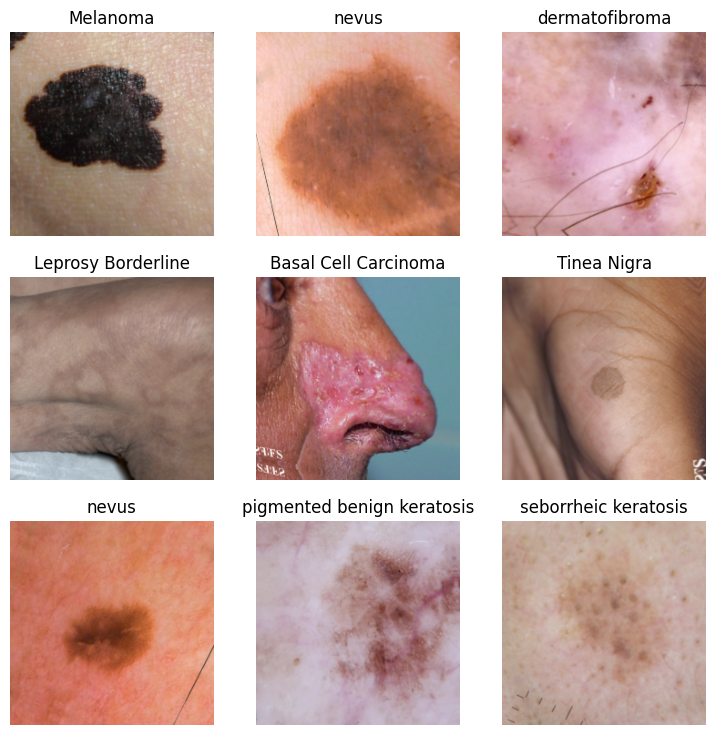

In [9]:
dls.show_batch()

In [ ]:
learn.summary()

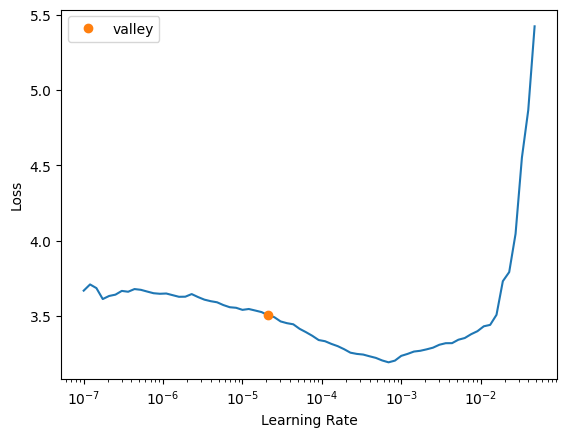

In [11]:
lr = learn.lr_find()

In [12]:
learn.fit(10, lr)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.537591,1.120421,0.656942,0.719633,0.641713,0.643177,01:52
1,0.897284,0.768313,0.743461,0.806675,0.738452,0.748889,02:04
2,0.523939,0.604510,0.797787,0.826644,0.813742,0.813263,02:22
3,0.357518,0.574363,0.810865,0.835286,0.819778,0.818050,02:19
4,0.276437,0.504715,0.835010,0.872831,0.830461,0.844478,02:19
5,0.213152,0.593215,0.810865,0.859796,0.805167,0.815600,02:20
6,0.167111,0.558740,0.825956,0.856046,0.846116,0.843028,02:22
7,0.185882,0.484706,0.836016,0.871069,0.839410,0.850689,02:22
8,0.137383,0.480912,0.855131,0.872034,0.871262,0.867794,02:22
9,0.115758,0.550515,0.850101,0.881971,0.850206,0.858453,02:20


Better model found at epoch 0 with valid_loss value: 1.120421290397644.
Better model found at epoch 1 with valid_loss value: 0.7683130502700806.
Better model found at epoch 2 with valid_loss value: 0.6045098900794983.
Better model found at epoch 3 with valid_loss value: 0.5743628740310669.
Better model found at epoch 4 with valid_loss value: 0.5047153830528259.
Better model found at epoch 7 with valid_loss value: 0.4847058057785034.
Better model found at epoch 8 with valid_loss value: 0.48091238737106323.


In [13]:
from fastai.vision.all import *

import shap

import matplotlib.pyplot as pl
from shap.plots import colors

In [14]:
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from fastai.vision.all import *
from fastai import *
import timm
from fastai.distributed import *

In [15]:
path = r'/kaggle/input/raw-paper'
bs = 32
sz = 224

data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y= parent_label,
    splitter= GrandparentSplitter(train_name = "train",valid_name = "val"),
    item_tfms=Resize(224))
    #batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = data.dataloaders(path, bs=bs,seed = 69)
print("Number of classes: ",dls.c)

Number of classes:  31


In [16]:
del data

In [20]:
arch =  "vit_base_patch16_224"
model = timm.create_model(arch, pretrained=False, in_chans=3, num_classes=31)
learn = Learner(dls, model, metrics=[accuracy,Precision(average='macro'), Recall(average='macro'), F1Score(average='macro')])
learn.load("/kaggle/working/_vit_base_patch16_224_opti_unaugmented")

In [21]:
learn.model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [22]:
preds = learn.get_preds()
pred_class = preds[0].max(1).indices
tgts = preds[1]

for i, name in enumerate(dls.train.vocab):
    idx = torch.nonzero(tgts==i)
    subset = (tgts == pred_class)[idx]
    acc = subset.squeeze().float().mean()
    print(f'{name}: {acc:.1%}')

AttributeError: 'NoneType' object has no attribute 'max'

In [24]:
preds

(None, None)